# Install environment
### you'll need [anaconda](https://www.anaconda.com/download)
### see [ultralytics](https://docs.ultralytics.com/quickstart/)
```bash
conda create -n kibo python=3.11
conda activate kibo
# Install the ultralytics package from PyPI
pip install ultralytics
pip install matplotlib
```
### You'll need to install [pytorch](https://pytorch.org/get-started/locally/)
### for windows with nvdia gpu
```bash
conda install cudatooolkit=11.8
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
### other os or gpu... god bless you

### TODO: env in google colab

# Check installation of pytorch

In [1]:
import torch
import os

print(torch.__version__)
if os.name == 'nt':
    # windows
    print(f'cuda: {torch.cuda.is_available()}')
else:
    # mac
    print(f'mps: {torch.backends.mps.is_available()}')


2.2.2+cu118
cuda: True


# Prepare [dataset](https://docs.ultralytics.com/zh/datasets/) by randomly generate items
### sturcture of dataset
```batch
dataset/
├── train/
│   ├── images/
│   └── labels/
└── val/
    ├── images/
    └── labels/
```

### create dataset sturcture

In [2]:
import os

print(f'current dir: {os.getcwd()}')

# create dataset sturcture
base_dir = os.getcwd()
dataset = os.path.join(base_dir, 'dataset')
os.makedirs(dataset, exist_ok=True)
os.makedirs(os.path.join(dataset, "train"), exist_ok=True)
os.makedirs(os.path.join(dataset, "val"), exist_ok=True)
os.makedirs(os.path.join(dataset, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(dataset, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(dataset, "val", "images"), exist_ok=True)
os.makedirs(os.path.join(dataset, "val", "labels"), exist_ok=True)

# print dataset structure
for root, dirs, files in os.walk(dataset):
    level = root.replace(dataset, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')

current dir: d:\Programming\JAVA\Kibo\kibo5th
dataset/
    train/
        images/
        labels/
    val/
        images/
        labels/


# create dataset
### config

train count: 8000, val count: 2000


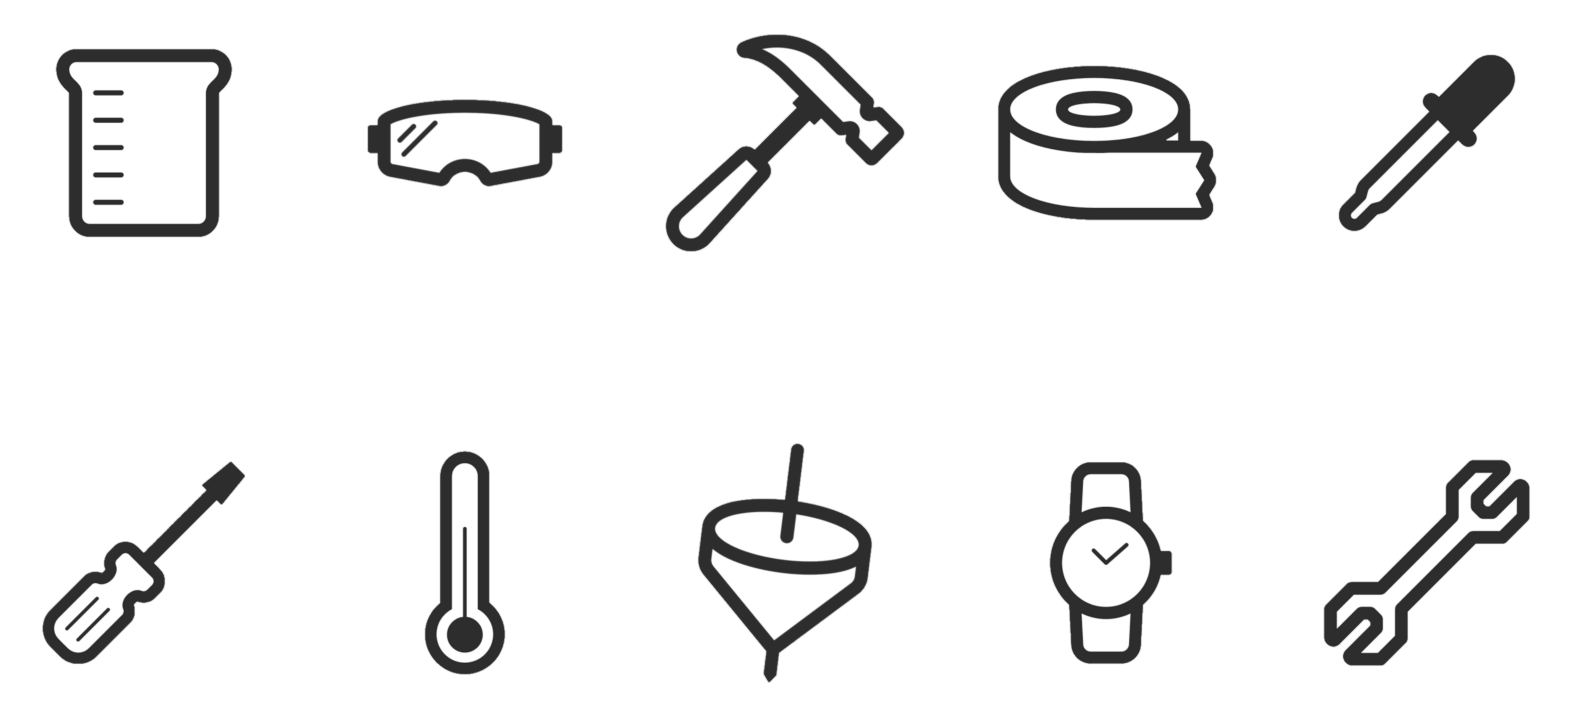

In [3]:
train_val_ratio = 0.8
data_count = 1e4

train_count = int(data_count * train_val_ratio)
val_count = int(data_count - train_count)
print(f'train count: {train_count}, val count: {val_count}')

width, height = 640, 480

# show images
from PIL import Image
import matplotlib.pyplot as plt

item_image_dir = "lost_item_images"
images = os.listdir(item_image_dir)
plt.subplots(2, 5, figsize=(20, 10))
for i, image in enumerate(images[:10]):
    img = Image.open(os.path.join(item_image_dir, image))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

### generate

item names: ['beaker', 'goggle', 'hammer', 'kapton_tape', 'pipette', 'screwdriver', 'thermometer', 'top', 'watch', 'wrench']
label: ('beaker', 3)
bboxs: [(0.31640625, 0.5635416666666667, 0.4109375, 0.5479166666666667), (0.56328125, 0.31145833333333334, 0.3546875, 0.47291666666666665), (0.66796875, 0.7447916666666666, 0.3140625, 0.41875)]


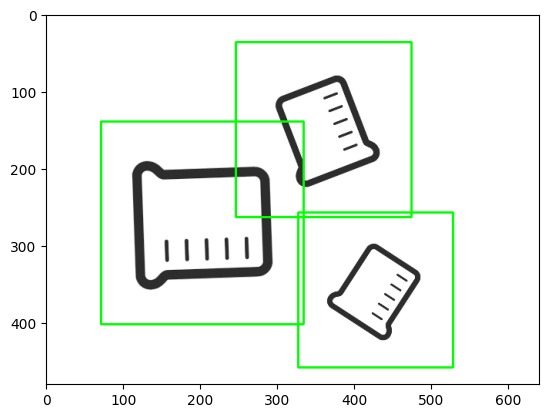

In [352]:
import random
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Assuming `images` is defined somewhere before this code snippet
item_names = [name.split(".")[0] for name in images]
print(f"item names: {item_names}")


def get_yolo_bbox(x1, y1, x2, y2, width, height):
    x_center = (x1 + x2) / (2 * width)
    y_center = (y1 + y2) / (2 * height)
    bbox_width = (x2 - x1) / width
    bbox_height = (y2 - y1) / height
    return x_center, y_center, bbox_width, bbox_height


def put_image(width, height, plane, item_image, x, y, angle, scale):
    item_height, item_width, channels = item_image.shape

    # Rotation matrix
    M = cv2.getRotationMatrix2D((item_width / 2, item_height / 2), angle, scale)
    rotated_corners = cv2.transform(
        np.array(
            [[[0, 0], [item_width, 0], [item_width, item_height], [0, item_height]]],
            dtype=np.float32,
        ),
        M,
    )[0]

    # Rotate image
    item_image_rotated = cv2.warpAffine(
        item_image, M, (item_width, item_height), borderValue=(255, 255, 255, 0)
    )

    x_min = int(min(rotated_corners[:, 0]))
    x_max = int(max(rotated_corners[:, 0]))
    y_min = int(min(rotated_corners[:, 1]))
    y_max = int(max(rotated_corners[:, 1]))

    # Cut the image
    item_image_rotated = item_image_rotated[y_min:y_max, x_min:x_max]

    x1 = x
    y1 = y
    x2 = x + item_image_rotated.shape[1]
    y2 = y + item_image_rotated.shape[0]

    if x1 < 0 or y1 < 0 or x2 > width or y2 > height:
        return False, None
    
    bbox = get_yolo_bbox(x1, y1, x2, y2, width, height)
    plane_slice = plane[y1:y2, x1:x2]

    # Alpha blending
    item_image_rotated_alpha = item_image_rotated[:, :, 3] / 255.0
    for c in range(3):
        plane_slice[:, :, c] = (
            plane_slice[:, :, c] * (1 - item_image_rotated_alpha)
            + item_image_rotated_alpha * item_image_rotated[:, :, c]
        )

    return True, bbox


def generate_image(item_image_dir, save_dir, height, width, count):
    images = []
    labels = []
    bboxs_list = []
    for i in range(count):
        item_name = random.choice(item_names)
        item_count = random.randint(1, 5)
        item_image = cv2.imread(
            os.path.join(item_image_dir, f"{item_name}.png"), cv2.IMREAD_UNCHANGED
        )  # Read image with alpha channel
        plane = (
            np.ones((height, width, 4), dtype=np.uint8) * 255
        )  # Initialize plane with alpha channel
        count = 0
        bboxs = []
        while count < item_count:
            scale = random.uniform(0.2, 0.6)
            x, y = random.randint(0, width), random.randint(0, height)
            angle = random.randint(0, 360)
            success, bbox = put_image(width, height, plane, item_image, x, y, angle, scale)
            if success:
                count += 1
                bboxs.append(bbox)
        images.append(plane)
        labels.append((item_name, item_count))
        bboxs_list.append(bboxs)
    return images, labels, bboxs_list


height = 480
width = 640
gen_images, gen_lables, bboxs_list = generate_image(item_image_dir, "", height, width, 1)
print(f"label: {gen_lables[0]}")
print(f"bboxs: {bboxs_list[0]}")
# draw bbox
for bbox in bboxs_list[0]:
    x_center, y_center, bbox_width, bbox_height = bbox
    x1 = int((x_center - bbox_width / 2) * width)
    y1 = int((y_center - bbox_height / 2) * height)
    x2 = int((x_center + bbox_width / 2) * width)
    y2 = int((y_center + bbox_height / 2) * height)
    cv2.rectangle(gen_images[0], (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(gen_images[0], cv2.COLOR_BGR2RGB))
plt.show()

# For more detail see [yolo doc](https://docs.ultralytics.com/quickstart/#install-ultralytics)

In [5]:
from ultralytics import YOLO

# Create a new YOLO model from scratch
model = YOLO("yolov8n.yaml")

# Load a pretrained YOLO model (recommended for training)
model = YOLO("yolov8n.pt")

# # Train the model using the 'coco128.yaml' dataset for 3 epochs
# results = model.train(data="coco128.yaml", epochs=3)

# # Evaluate the model's performance on the validation set
# results = model.val()

# # Perform object detection on an image using the model
# results = model("https://ultralytics.com/images/bus.jpg")

# Export the model to ONNX format
success = model.export(format="onnx")

Ultralytics YOLOv8.1.41 🚀 Python-3.11.8 torch-2.2.2+cu118 CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 0.8s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (2.6s)
Results saved to D:\Programming\JAVA\Kibo\kibo5th
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app
